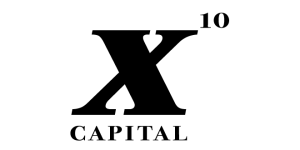

# X-10 Capital: Technical Assignment - Analyst

Julian Ibarra
<br>
October 26, 2020

#### Objective: 
- Predict the probability that a player will play under the contract in each remaining year of his deal. 
- Use 'is_dead' as the dependent variable. 

In [331]:
# Import necessary libraries
import os

from pandas import read_excel
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.formula.api as smf
from sklearn import preprocessing,metrics
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [332]:
# Set working directory
os.chdir("/Users/jiibarra47/Documents/Data")

# Import the training and test datasets
my_sheet = 'TRAINING'
my_sheet2 = 'TO PREDICT'
file_name = 'nfl_contract_data.xlsx'
train = read_excel(file_name, sheet_name = my_sheet)
predict = read_excel(file_name, sheet_name = my_sheet2)

# Print data dimensions
print("train dimensions: {}".format(train.shape))
print("predict dimensions: {}".format(predict.shape))

train dimensions: (2997, 44)
predict dimensions: (618, 44)


In [333]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2997 entries, 0 to 2996
Data columns (total 44 columns):
spotrac_id               2997 non-null int64
age                      2997 non-null int64
base_salary              2997 non-null float64
cap_hit                  2997 non-null float64
contract_no              2997 non-null float64
contract_year            2997 non-null int64
dead                     2997 non-null float64
dead_cap_hit             2997 non-null float64
incentive                2997 non-null int64
misc                     2997 non-null float64
option_bonus             2997 non-null float64
restruc_bonus            2997 non-null float64
roster_bonus             2997 non-null float64
signing_bonus            2997 non-null float64
status                   2997 non-null object
workout_bonus            2997 non-null float64
year                     2997 non-null int64
in_annual_withage        2997 non-null int64
mapped_deal              2997 non-null int64
average_salary 

In [334]:
# Display the first 10 rows of the training data
train.head(10)

,spotrac_id,age,base_salary,cap_hit,contract_no,contract_year,dead,dead_cap_hit,incentive,misc,...,start_year,end_year,duration,exactly_1_year_deal,current_deal,is_current,is_dead,rookie_extension,franchise_tag,salary_cap
0,955,36,3.099102e+06,4.507784e+06,11.269461,1,0.000000e+00,0.000000,0,1.408683e+06,...,2017,2017,1,1,0,0,1,0,0,167.0
1,966,34,1.239641e+07,1.786210e+07,6.761677,1,0.000000e+00,0.000000,0,0.000000e+00,...,2017,2018,2,0,0,0,0,0,0,167.0
2,966,35,1.239641e+07,1.898904e+07,6.761677,2,1.786210e+07,0.000000,0,1.126946e+06,...,2017,2018,2,0,0,0,0,0,0,167.0
3,1068,0,0.000000e+00,0.000000e+00,14.650299,1,0.000000e+00,309910.179641,0,0.000000e+00,...,2017,2017,1,1,0,0,1,0,0,167.0
4,1068,32,1.014251e+06,1.408683e+06,11.269461,1,3.099102e+05,0.000000,0,0.000000e+00,...,2017,2018,2,0,0,0,1,0,0,167.0
5,1068,33,1.408683e+06,1.521377e+06,11.269461,2,0.000000e+00,0.000000,0,0.000000e+00,...,2017,2018,2,0,0,0,1,0,0,167.0
6,1068,32,1.126946e+06,1.169207e+06,10.142515,1,1.211467e+06,0.000000,0,0.000000e+00,...,2017,2018,2,0,0,0,0,0,0,167.0
7,1068,33,1.408683e+06,1.563638e+06,10.142515,2,4.226048e+04,0.000000,0,0.000000e+00,...,2017,2018,2,0,0,0,1,0,0,167.0
8,3182,33,3.380838e+06,5.036040e+06,6.761677,1,5.634731e+06,0.000000,0,0.000000e+00,...,2017,2018,2,0,0,0,0,0,0,167.0
9,3182,34,5.634731e+06,6.937762e+06,6.761677,2,1.126946e+06,0.000000,0,0.000000e+00,...,2017,2018,2,0,0,0,1,0,0,167.0


In [335]:
# Display the first 10 rows of the prediction data
predict.head(10)

,spotrac_id,age,base_salary,cap_hit,contract_no,contract_year,dead,dead_cap_hit,incentive,misc,...,start_year,end_year,duration,exactly_1_year_deal,current_deal,is_current,is_dead,rookie_extension,franchise_tag,salary_cap
0,4693,32,2.253892e+06,3.380838e+06,9.015569,1,5.634731e+06,0,0,0.0,...,2017,2019,3,0,0,1,0,0,0,167.0
1,4693,33,3.380838e+06,5.071257e+06,9.015569,2,6.198204e+06,0,0,0.0,...,2017,2019,3,0,0,1,0,0,0,167.0
2,4693,34,2.817365e+06,3.944311e+06,9.015569,3,1.126946e+06,0,0,0.0,...,2017,2019,3,0,1,1,0,0,0,167.0
3,9855,27,1.126946e+06,1.211467e+07,4.507784,1,1.774940e+07,0,0,0.0,...,2017,2023,7,0,0,1,0,0,0,167.0
4,9855,28,1.126946e+06,4.479611e+06,4.507784,2,2.806096e+07,0,0,0.0,...,2017,2023,7,0,0,1,0,0,0,167.0
5,9855,29,1.048060e+06,6.839436e+06,4.507784,3,2.329961e+07,0,0,0.0,...,2017,2023,7,0,1,1,0,0,0,167.0
6,9855,30,1.436856e+07,2.044168e+07,4.507784,4,1.758712e+07,0,0,0.0,...,2017,2023,7,0,0,1,0,0,0,167.0
7,9855,31,1.436856e+07,2.044168e+07,4.507784,5,1.066880e+07,0,0,0.0,...,2017,2023,7,0,0,1,0,0,0,167.0
8,9855,32,0.000000e+00,2.438711e+06,4.507784,6,4.877423e+06,0,0,0.0,...,2017,2023,7,0,0,1,0,0,0,167.0
9,9855,33,0.000000e+00,2.438711e+06,4.507784,7,0.000000e+00,0,0,0.0,...,2017,2023,7,0,0,1,0,0,0,167.0


## Data Cleaning & Feature Engineering

In [336]:
# Drop columns that are not related to the target variable ('is_dead') and/or are redundant.
del_cols = ["date_of_birth", "spotrac_id", "year", "in_annual_withage", "name", "pfr_pos", "incentive",
           "guaranteed_at_signing", "total_guarantees"]
train = train.drop(labels = del_cols, axis = 1) 
predict = predict.drop(labels = del_cols, axis = 1)
print("train dimensions: {}".format(train.shape))
print("predict dimensions {}".format(predict.shape))

train dimensions: (2997, 35)
predict dimensions (618, 35)


In [337]:
train2.describe()

,base_salary,cap_hit,contract_no,contract_year,dead,dead_cap_hit,misc,option_bonus,restruc_bonus,roster_bonus,...,draft_year,fyo,start_year,end_year,duration,exactly_1_year_deal,is_dead,rookie_extension,franchise_tag,salary_cap
count,2.997000e+03,2.997000e+03,2997.000000,2997.000000,2.997000e+03,2.997000e+03,2.997000e+03,2.997000e+03,2.997000e+03,2.997000e+03,...,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000
mean,1.808154e+06,2.554968e+06,4.093427,1.935936,2.342312e+06,1.703906e+05,2.623281e+04,8.001442e+04,8.019331e+04,1.519685e+05,...,1298.724391,0.011345,2014.229897,2016.101768,2.871872,0.284618,0.544211,0.025025,0.002669,143.252586
std,3.495745e+06,4.787064e+06,3.135664,1.218693,3.520767e+07,1.006595e+06,3.512584e+05,5.033013e+05,6.516025e+05,8.174277e+05,...,962.307500,0.105923,3.322788,2.884860,1.623714,0.451308,0.498125,0.156227,0.051605,24.017029
min,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,2001.000000,2003.000000,1.000000,0.000000,0.000000,0.000000,0.000000,67.000000
25%,2.447180e+05,1.782947e+04,2.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,2012.000000,2014.000000,1.000000,0.000000,0.000000,0.000000,0.000000,123.000000
50%,7.216692e+05,7.496940e+05,3.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2009.000000,0.000000,2015.000000,2017.000000,3.000000,0.000000,1.000000,0.000000,0.000000,143.000000
75%,1.170495e+06,2.087038e+06,5.000000,3.000000,2.402216e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2013.000000,0.000000,2017.000000,2018.000000,4.000000,1.000000,1.000000,0.000000,0.000000,167.000000
max,4.053276e+07,4.580167e+07,22.000000,8.000000,1.905373e+09,2.112000e+07,1.152916e+07,9.696657e+06,1.390173e+07,1.391121e+07,...,2019.000000,1.000000,2019.000000,2022.000000,8.000000,1.000000,1.000000,1.000000,1.000000,188.000000


In [338]:
# Encode 'status' to numerical values. 'dead' = 0, 'historical' = 1.
train['status'] = train['status'].map({'dead':0, 'historical':1})
predict['status'] = predict['status'].map({'dead':0, 'historical':1})
train['fa_status'] = train['fa_status'].map({'ufa':0, 'rfa':1, 'erfa':2})
predict['fa_status'] = predict['fa_status'].map({'ufa':0, 'rfa':1, 'erfa':2})
train.head(5)

,age,base_salary,cap_hit,contract_no,contract_year,dead,dead_cap_hit,misc,option_bonus,restruc_bonus,...,start_year,end_year,duration,exactly_1_year_deal,current_deal,is_current,is_dead,rookie_extension,franchise_tag,salary_cap
0,36,3.099102e+06,4.507784e+06,11.269461,1,0.000000e+00,0.000000,1.408683e+06,0.000000e+00,0.000000e+00,...,2017,2017,1,1,0,0,1,0,0,167.0
1,34,1.239641e+07,1.786210e+07,6.761677,1,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.648323e+06,...,2017,2018,2,0,0,0,0,0,0,167.0
2,35,1.239641e+07,1.898904e+07,6.761677,2,1.786210e+07,0.000000,1.126946e+06,2.648323e+06,0.000000e+00,...,2017,2018,2,0,0,0,0,0,0,167.0
3,0,0.000000e+00,0.000000e+00,14.650299,1,0.000000e+00,309910.179641,0.000000e+00,0.000000e+00,0.000000e+00,...,2017,2017,1,1,0,0,1,0,0,167.0
4,32,1.014251e+06,1.408683e+06,11.269461,1,3.099102e+05,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2017,2018,2,0,0,0,1,0,0,167.0


In [339]:
# Round selected columns to the nearest integer
cols = ["contract_no", "dead_cap_hit", "roster_bonus", "workout_bonus", "guaranteed",
       "salary_cap", "draft_year", "draft_round", "fa_year", "contract_term"]
train[cols] = train[cols].apply(lambda x: round(x))
predict[cols] = predict[cols].apply(lambda x: round(x))
train.head(5)


,age,base_salary,cap_hit,contract_no,contract_year,dead,dead_cap_hit,misc,option_bonus,restruc_bonus,...,start_year,end_year,duration,exactly_1_year_deal,current_deal,is_current,is_dead,rookie_extension,franchise_tag,salary_cap
0,36,3.099102e+06,4.507784e+06,11.0,1,0.000000e+00,0.0,1.408683e+06,0.000000e+00,0.000000e+00,...,2017,2017,1,1,0,0,1,0,0,167.0
1,34,1.239641e+07,1.786210e+07,7.0,1,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.648323e+06,...,2017,2018,2,0,0,0,0,0,0,167.0
2,35,1.239641e+07,1.898904e+07,7.0,2,1.786210e+07,0.0,1.126946e+06,2.648323e+06,0.000000e+00,...,2017,2018,2,0,0,0,0,0,0,167.0
3,0,0.000000e+00,0.000000e+00,15.0,1,0.000000e+00,309910.0,0.000000e+00,0.000000e+00,0.000000e+00,...,2017,2017,1,1,0,0,1,0,0,167.0
4,32,1.014251e+06,1.408683e+06,11.0,1,3.099102e+05,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,2017,2018,2,0,0,0,1,0,0,167.0


## Filling Missing Values and Feature Scaling

In [340]:
# Impute missing 
# Fill in any 'NaN' values in the train and predict data with 0. 
train = train.fillna(0)
predict = predict.fillna(0)
# Verify that ther are no 'NaN' values in the training data.
train.isnull().sum()

age                    0
base_salary            0
cap_hit                0
contract_no            0
contract_year          0
dead                   0
dead_cap_hit           0
misc                   0
option_bonus           0
restruc_bonus          0
roster_bonus           0
signing_bonus          0
status                 0
workout_bonus          0
mapped_deal            0
average_salary         0
guaranteed             0
total_signing_bonus    0
contract_term          0
contract_value         0
fa_year                0
fa_status              0
draft_round            0
draft_year             0
fyo                    0
start_year             0
end_year               0
duration               0
exactly_1_year_deal    0
current_deal           0
is_current             0
is_dead                0
rookie_extension       0
franchise_tag          0
salary_cap             0
dtype: int64

In [341]:
# Scale the data using MinMaxScaler() function
scl = preprocessing.MinMaxScaler()
f = train.columns.values[:-1]
fp = predict.columns.values[:-1]
train_clean = pd.DataFrame(scl.fit_transform(train[f]), columns = f)
predict_clean = pd.DataFrame(scl.fit_transform(predict[fp]), columns = fp)

# Keep my target (is_dead) as 0="Not Resigned" and 1="Resigned"
train_clean['is_dead'] = train['is_dead']
predict_clean['is_dead'] = predict['is_dead']
train_clean['is_dead'].value_counts()

1    1631
0    1366
Name: is_dead, dtype: int64

In [342]:
train_clean.head()

,age,base_salary,cap_hit,contract_no,contract_year,dead,dead_cap_hit,misc,option_bonus,restruc_bonus,...,fyo,start_year,end_year,duration,exactly_1_year_deal,current_deal,is_current,is_dead,rookie_extension,franchise_tag
0,0.035122,0.076459,0.098420,0.476190,0.000000,0.000000,0.000000,0.122184,0.000000,0.000000,...,0.0,0.888889,0.736842,0.000000,1.0,0.0,0.0,1,0.0,0.0
1,0.033171,0.305837,0.389988,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.190503,...,0.0,0.888889,0.789474,0.142857,0.0,0.0,0.0,0,0.0,0.0
2,0.034146,0.305837,0.414593,0.285714,0.142857,0.009375,0.000000,0.097747,0.273117,0.000000,...,0.0,0.888889,0.789474,0.142857,0.0,0.0,0.0,0,0.0,0.0
3,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.014674,0.000000,0.000000,0.000000,...,0.0,0.888889,0.736842,0.000000,1.0,0.0,0.0,1,0.0,0.0
4,0.031220,0.025023,0.030756,0.476190,0.000000,0.000163,0.000000,0.000000,0.000000,0.000000,...,0.0,0.888889,0.789474,0.142857,0.0,0.0,0.0,1,0.0,0.0


In [343]:
# Below are the correlation values between the selected features
train_clean.corrwith(train.is_dead).sort_values(ascending=False)

is_dead                1.000000
start_year             0.381345
contract_no            0.305073
exactly_1_year_deal    0.249120
end_year               0.246211
dead_cap_hit           0.154939
draft_round            0.059661
fyo                    0.022121
contract_year          0.012915
franchise_tag         -0.004592
restruc_bonus         -0.015921
rookie_extension      -0.016366
base_salary           -0.024357
fa_status             -0.051329
dead                  -0.055109
workout_bonus         -0.065784
misc                  -0.066597
option_bonus          -0.067043
draft_year            -0.096008
roster_bonus          -0.106247
cap_hit               -0.124862
guaranteed            -0.145488
signing_bonus         -0.154099
contract_value        -0.163470
age                   -0.192766
total_signing_bonus   -0.200218
average_salary        -0.200420
mapped_deal           -0.230404
duration              -0.342944
contract_term         -0.437089
fa_year               -0.474335
status  

## ROC Curve Plot function

This is a callable ROC curve plot function. I used this function to plot ROC Curve for all the models. We have used scikitplot package.

In [344]:
import scikitplot as skplt
def plotAUC(truth, pred):
    plot = skplt.metrics.plot_roc(y_val, y_pred_prob, figsize=(8,6))
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve') 
    plt.legend(loc="lower right")

## Confusion Matrix function

This is a callable Confusion Matrix Visualization function. I used this function to visualize True positives, True Negatives, False Positives and False Negatives for all the models.

In [345]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_val, model, labels=[0, 1])
    classes=["Will Play", "Will Not Play"]
    cmap = plt.cm.Greens
    title = "Will vs. Will Not Play"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

#### Split 'TRAIN' dataset into training/validation sets

In [346]:
# Shuffle your dataset 
shuffle_df = train_clean.sample(frac=1)

X = train_clean.drop('is_dead', axis=1, inplace = False)
y = train_clean[['is_dead']]

# Split 'TRAIN' data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.30, random_state=1)
X_test = predict_clean.drop('is_dead', axis=1, inplace = False) 

#Print data dimensions
print("X_train dimensions: {}".format(X_train.shape))
print("X_validation dimensions: {}".format(X_val.shape))
print("y_train dimensions: {}".format(y_train.shape))
print("y_validation dimensions: {}".format(y_val.shape))

print("X_test dimensions: {}".format(X_test.shape))

X_train dimensions: (2097, 33)
X_validation dimensions: (900, 33)
y_train dimensions: (2097, 1)
y_validation dimensions: (900, 1)
X_test dimensions: (618, 33)


## Recursive Feature Elimination

RFE is a wrapper-type feature selection algorithm. This means that a different machine learning algorithm is given and used in the core of the method, is wrapped by RFE, and used to help select features. This is in contrast to filter-based feature selections that score each feature and select those features with the largest (or smallest) score.

RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.

In [347]:
from sklearn.feature_selection import RFE
estimator = RandomForestRegressor(random_state = 42)
selector = RFE(estimator, 12, step=1)
selector = selector.fit(X_train, y_train)
rfe_mask = selector.get_support() #list of booleans for selected features
new_features = [] 
for bool, feature in zip(rfe_mask, X_train.columns):
 if bool:
     new_features.append(feature)
# Print the selected features
new_features

['age',
 'cap_hit',
 'dead_cap_hit',
 'misc',
 'status',
 'fa_year',
 'fa_status',
 'draft_round',
 'draft_year',
 'fyo',
 'start_year',
 'end_year']

Determine the features that are correlated to the target variable: 'is_dead'

In [348]:
# Create new train/predict datasets excluding variables that are correlated to 'is_dead'
variables = ['dead_cap_hit', 'age', 'cap_hit', 'fa_status', 'draft_round', 'draft_year', 'fyo', 'start_year', 
             'end_year', 'misc', 'fa_year', 'is_dead']
# X_train, X_val = X_train[variables[:-1]], X_val[variables[:-1]]
train_final = train_clean[variables]
predict_final = predict_clean[variables]

X = train_final.drop('is_dead', axis=1, inplace=False)
y = train_final[['is_dead']]
# Split 'train_final' data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.30, random_state=42)
# Print the train, validation, and test set dimensions
X_test = predict_final.drop('is_dead', axis=1, inplace=False)
print("X_train dimensions: {}".format(X_train.shape))
print("X_val dimensions: {}".format(X_val.shape))
print("y_train dimensions: {}".format(y_train.shape))
print("y_val dimensions: {}".format(y_val.shape))
print("X_test dimensions: {}".format(X_test.shape))
print("train_final dimensions: {}".format(train_final.shape))


X_train dimensions: (2097, 11)
X_val dimensions: (900, 11)
y_train dimensions: (2097, 1)
y_val dimensions: (900, 1)
X_test dimensions: (618, 11)
train_final dimensions: (2997, 12)


### Correlation Heat Map

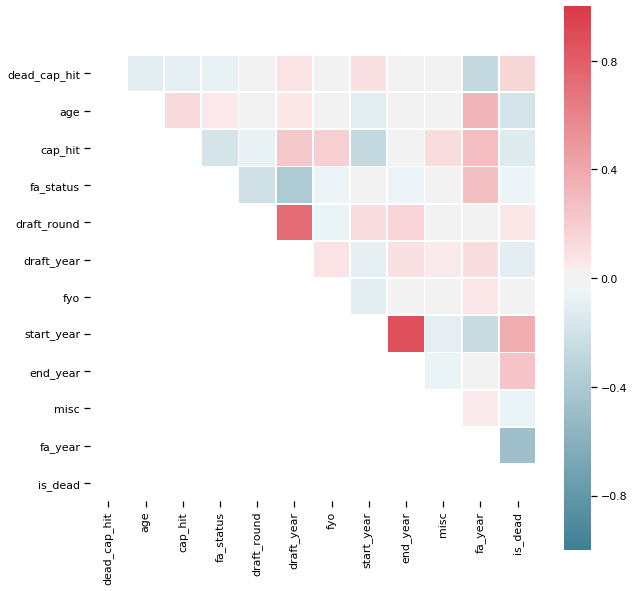

In [349]:
dataViz = train_final
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, 
            square=True, cbar=True, center=0, ax=ax, mask=mask)

In [350]:
train_final.head()

,dead_cap_hit,age,cap_hit,fa_status,draft_round,draft_year,fyo,start_year,end_year,misc,fa_year,is_dead
0,0.000000,0.035122,0.098420,0.0,0.285714,0.992075,0.0,0.888889,0.736842,0.122184,0.997528,1
1,0.000000,0.033171,0.389988,0.0,0.142857,0.992571,0.0,0.888889,0.789474,0.000000,0.000000,0
2,0.000000,0.034146,0.414593,0.0,0.142857,0.992571,0.0,0.888889,0.789474,0.097747,0.000000,0
3,0.014674,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.888889,0.736842,0.000000,0.000000,1
4,0.000000,0.031220,0.030756,0.0,0.000000,0.000000,0.0,0.888889,0.789474,0.000000,0.998023,1


In [351]:
X_test.head()

,dead_cap_hit,age,cap_hit,fa_status,draft_round,draft_year,fyo,start_year,end_year,misc,fa_year
0,0.0,0.7500,0.137993,0.0,0.142857,0.994056,0.0,0.5,0.0,0.0,0.997531
1,0.0,0.8125,0.206990,0.0,0.142857,0.994056,0.0,0.5,0.0,0.0,0.997531
2,0.0,0.8750,0.160992,0.0,0.142857,0.994056,0.0,0.5,0.0,0.0,0.997531
3,0.0,0.4375,0.494476,0.0,0.285714,0.996533,0.0,0.5,0.8,0.0,0.998519
4,0.0,0.5000,0.182841,0.0,0.285714,0.996533,0.0,0.5,0.8,0.0,0.998519


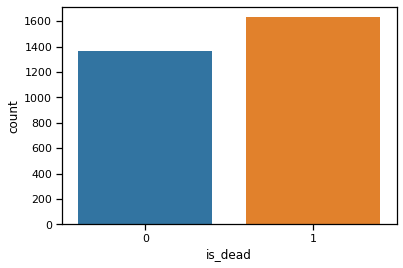

In [352]:
# Plot 'is_dead' using final training data
sns.countplot(train_final['is_dead'])

#### Observations:  _(training set only!)_
 - Approximately 1390 players did not continue to play through their remaining contract.
<br>
 - Approximatley 1600 players did play through their remaining contract.
<br>
 - The dataset is unbalanced where one category outnumbers the other.

## Models: Logistic Regression, SVM, KNN with Grid Search

Grid Search is a tuning technique that attempts to compute the optimum values of hyperparameters. It is an exhaustive search that is performed on a the specific parameter values of a model. The model is also known as an estimator.
<br>
#### Approach:
- I will create several classifiers and run them against the training dataset using GridSearch to find optimum hyperparameters. 

### Logistic Regression with Grid Search
<br>
Logistic Regression when implemented with grid search gave me an accuracy = 64% and a very low false negative of 0.062. I used Grid Search to find the best hyperparameters and model, then plot an ROC curve.  

In [353]:
# Perform Grid Serach
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],
               'C':[0.001,.009,0.01,.09,1,5,10,100,1000]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, scoring = 'recall')

log_model = grid_clf_acc.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_clf_acc = log_model.predict(X_val)
y_pred_prob = log_model.predict_proba(X=X_val)

# Print the best parameters and model after hyper-parameter tuning
print(grid_clf_acc.best_params_)
print(grid_clf_acc.best_estimator_)

# Print prediction results
print(classification_report(y_val, y_pred_clf_acc))

# New Model Evaluation metrics 
print("Accuracy Score: " + str(accuracy_score(y_val,y_pred_clf_acc)))
print("Precision Score: " + str(precision_score(y_val,y_pred_clf_acc)))
print("Recall Score: " + str(recall_score(y_val,y_pred_clf_acc)))
print("F1 Score: " + str(f1_score(y_val,y_pred_clf_acc)))

{'C': 0.001, 'penalty': 'l2'}
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.78      0.28      0.41       402
           1       0.62      0.94      0.74       498

   micro avg       0.64      0.64      0.64       900
   macro avg       0.70      0.61      0.58       900
weighted avg       0.69      0.64      0.59       900

Accuracy Score: 0.6422222222222222
Precision Score: 0.6160949868073878
Recall Score: 0.9377510040160643
F1 Score: 0.7436305732484076


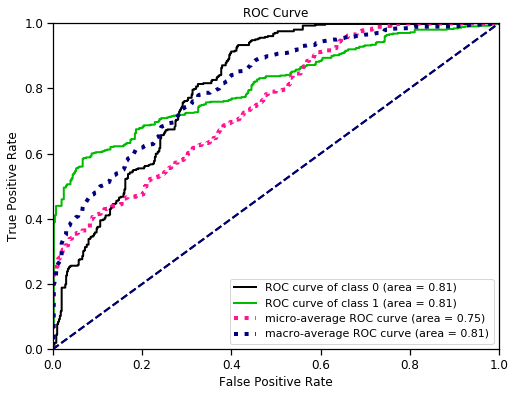

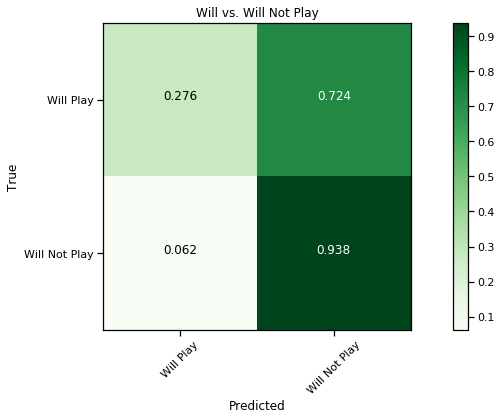

In [354]:
plotAUC(y_val, y_pred_prob)
plt.show()
plt.figure(figsize=(12,6))
plot_confusion_matrix(y_pred_clf_acc, normalize = True)
plt.tight_layout()
plt.show()

### Support Vector Machine with Grid Search
<br>
SVM (Support Vector Machines) when implemented with Grid Search gave good accuracy at 77.44% and low false negative of 0.253. I used Grid Search to find the best hyper parameters for the model. I then used this value to plot the ROC curve.

In [355]:
# Import Support Vector Machine package from sklearn
from sklearn.svm import SVC
sv = SVC(probability=True)
grid_values = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}
grid_sv_acc = GridSearchCV(sv, param_grid = grid_values, refit = True, verbose = 3)

sv_model = grid_sv_acc.fit(X_train, np.ravel(y_train))

# Predict values based on new parameters
y_pred_svc_acc = sv_model.predict(X_val)
y_pred_prob = sv_model.predict_proba(X=X_val)

# Print the best parameters and model after hyper-parameter tuning
print(grid_sv_acc.best_params_)
print(grid_sv_acc.best_estimator_)

# Print prediction results
print(classification_report(y_val, y_pred_svc_acc)) 

# New Model Evaluation metrics 
print("Accuracy Score: " + str(accuracy_score(y_val,y_pred_svc_acc)))
print("Precision Score: " + str(precision_score(y_val,y_pred_svc_acc)))
print("Recall Score: " + str(recall_score(y_val,y_pred_svc_acc)))
print("F1 Score: " + str(f1_score(y_val,y_pred_svc_acc)))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, gamma=1, kernel=rbf, score=0.7271428571428571, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  C=0.1, gamma=1, kernel=rbf, score=0.7625178826895566, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  C=0.1, gamma=1, kernel=rbf, score=0.7020057306590258, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.6757142857142857, total=   0.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.6995708154506438, total=   0.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.6762177650429799, total=   0.3s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ........ C=0.1, gamma=0.01, kernel=rbf, score=0.54, total=   0.3s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV]  C=0.1, gamma=0.01, kernel=rbf, score=0.5407725321888412, total=   0.3s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV]  C=0.1, gamma=0.01, kernel=rbf, score=0.5401146131805158, total=   0.3s
[CV] C=0.1, gamma=0.001, kernel=rbf ...........

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   20.7s finished


{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       402
           1       0.83      0.75      0.79       498

   micro avg       0.77      0.77      0.77       900
   macro avg       0.77      0.78      0.77       900
weighted avg       0.78      0.77      0.78       900

Accuracy Score: 0.7744444444444445
Precision Score: 0.8285077951002228
Recall Score: 0.7469879518072289
F1 Score: 0.7856388595564943


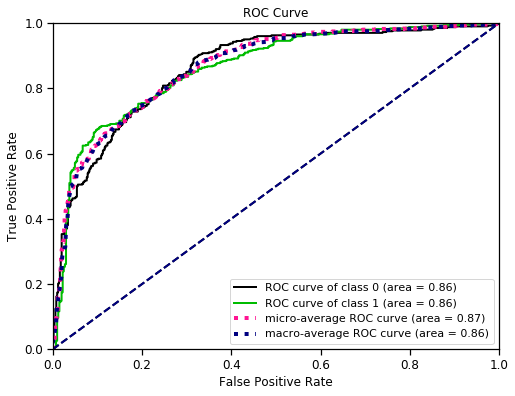

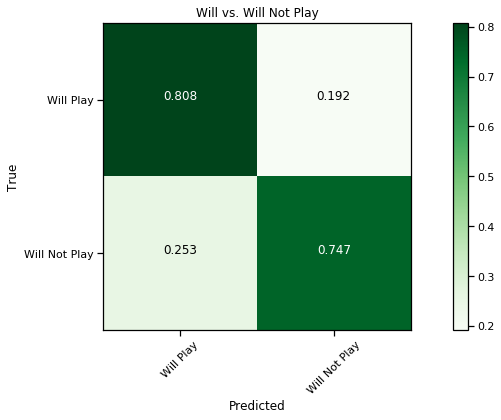

In [356]:
plotAUC(y_val, y_pred_prob)
plt.show()
plt.figure(figsize=(12,6))
plot_confusion_matrix(y_pred_svc_acc, normalize = True)
plt.tight_layout()
plt.show()

### KNN with Grid Search
<br>
KNN (K Nearest Neighbors) when implemented with grid search gave me the best accuracy out of all the models at 78% and low false negatives at 0.211. I used the Grid Search to find the best hyper paramters for the model, then used the value to find the predictions and plot an ROC curve. 

In [357]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
grid_values = {'n_neighbors':[3,5,11,19],
               'weights':['uniform', 'distance'],
               'metric':['euclidean', 'manhattan']
              }
grid_kn_acc = GridSearchCV(clf, param_grid = grid_values, cv = 5)

knn_model = grid_kn_acc.fit(X_train, np.ravel(y_train))

#Predict values based on new parameters
y_pred_kn_acc = knn_model.predict(X_val)
y_pred_prob = knn_model.predict_proba(X=X_val)

# Print the best parameters and model after hyper-parameter tuning
print(grid_kn_acc.best_params_)
print(grid_kn_acc.best_estimator_)

# Print prediction results
print(classification_report(y_val, y_pred_kn_acc))

# New Model Evaluation metrics 
print("Accuracy Score: " + str(accuracy_score(y_val,y_pred_kn_acc)))
print("Precision Score: " + str(precision_score(y_val,y_pred_kn_acc)))
print("Recall Score: " + str(recall_score(y_val,y_pred_kn_acc)))
print("F1 Score: " + str(f1_score(y_val,y_pred_kn_acc)))

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='distance')
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       402
           1       0.81      0.79      0.80       498

   micro avg       0.78      0.78      0.78       900
   macro avg       0.78      0.78      0.78       900
weighted avg       0.78      0.78      0.78       900

Accuracy Score: 0.7833333333333333
Precision Score: 0.8136645962732919
Recall Score: 0.7891566265060241
F1 Score: 0.8012232415902141


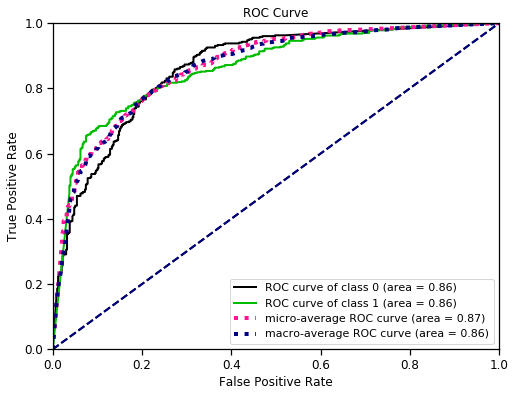

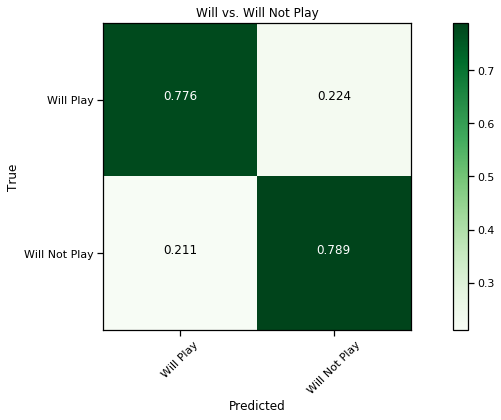

In [358]:
plotAUC(y_val, y_pred_prob)
plt.show()
plt.figure(figsize=(12,6))
plot_confusion_matrix(y_pred_kn_acc, normalize = True)
plt.tight_layout()
plt.show()

#### Results: 

- KNN performed the best on all three metrics: Accuracy = 78.33%, Precision = 81.37%, Recall Score = 78.91%, and F1 Score = 80.12%.
<br>
- The next steps will be to use the KNN model to predict the results on the test/prediction dataset. 

## Prediction using the Test Dataset

Will the player play under contract in the remaining year of his deal?
<br>
0 = no
<br>
1 = yes

In [359]:
# Predict the results on the test dataset
y_pred = knn_model.predict(X_test)  # GBC with all features
predict['Will Play'] = y_pred

# Show first 30 rows of predicted values
predict.head(30)

,age,base_salary,cap_hit,contract_no,contract_year,dead,dead_cap_hit,misc,option_bonus,restruc_bonus,...,end_year,duration,exactly_1_year_deal,current_deal,is_current,is_dead,rookie_extension,franchise_tag,salary_cap,Will Play
0,32,2.253892e+06,3.380838e+06,9.0,1,5.634731e+06,0,0.000000,0.000000e+00,0.000000e+00,...,2019,3,0,0,1,0,0,0,167.0,0
1,33,3.380838e+06,5.071257e+06,9.0,2,6.198204e+06,0,0.000000,0.000000e+00,0.000000e+00,...,2019,3,0,0,1,0,0,0,167.0,0
2,34,2.817365e+06,3.944311e+06,9.0,3,1.126946e+06,0,0.000000,0.000000e+00,0.000000e+00,...,2019,3,0,1,1,0,0,0,167.0,0
3,27,1.126946e+06,1.211467e+07,5.0,1,1.774940e+07,0,0.000000,0.000000e+00,0.000000e+00,...,2023,7,0,0,1,0,0,0,167.0,1
4,28,1.126946e+06,4.479611e+06,5.0,2,2.806096e+07,0,0.000000,1.943982e+06,0.000000e+00,...,2023,7,0,0,1,0,0,0,167.0,0
5,29,1.048060e+06,6.839436e+06,5.0,3,2.329961e+07,0,0.000000,1.943982e+06,2.438711e+06,...,2023,7,0,1,1,0,0,0,167.0,0
6,30,1.436856e+07,2.044168e+07,5.0,4,1.758712e+07,0,0.000000,1.943982e+06,2.438711e+06,...,2023,7,0,0,1,0,0,0,167.0,1
7,31,1.436856e+07,2.044168e+07,5.0,5,1.066880e+07,0,0.000000,1.943982e+06,2.438711e+06,...,2023,7,0,0,1,0,0,0,167.0,1
8,32,0.000000e+00,2.438711e+06,5.0,6,4.877423e+06,0,0.000000,0.000000e+00,2.438711e+06,...,2023,7,0,0,1,0,0,0,167.0,0
9,33,0.000000e+00,2.438711e+06,5.0,7,0.000000e+00,0,0.000000,0.000000e+00,2.438711e+06,...,2023,7,0,0,1,0,0,0,167.0,0


#### If I had more time I would have liked to:
- Implement a learning curve to identify the prediction accuracy/error vs. the size of my training set. It would basically allow me to get a better idea of how well the model predicts my target value as I increase the number of instances I use to train it. 
- I would have also liked to utilize additional classification models, as I only used 3 for this assignment. (i.e: Naive Bayes, Decision Tree, Random Forest).
- Use the time to perform more elegant data cleansing and transformation.

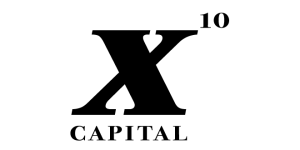